In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from pytrends.request import TrendReq
from sklearn import preprocessing
import matplotlib.pyplot as plt

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)
y.tail()

,BasicEPS
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27
2023-09-30,1.47


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [7]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iPhone", "Mac", "iPad", "Apple layoff", "Apple Share Price", "Chip Costs", 
            "Anime", "Church", "Suits"]
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]
    
df.head()

,iPhone,Mac,iPad,Apple layoff,Apple Share Price,Chip Costs,Anime,Church,Suits
date,,,,,,,,,
2004-01-01,0,78,0,0,1,35,52,89,39
2004-02-01,0,75,0,0,0,0,48,92,45
2004-03-01,0,67,0,0,0,0,50,92,46
2004-04-01,0,74,0,100,4,0,53,93,48
2004-05-01,0,69,0,0,3,23,53,77,50


In [8]:
X = df.resample("Q").mean()

In [9]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [12]:
lasso = Lasso(alpha = .5)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

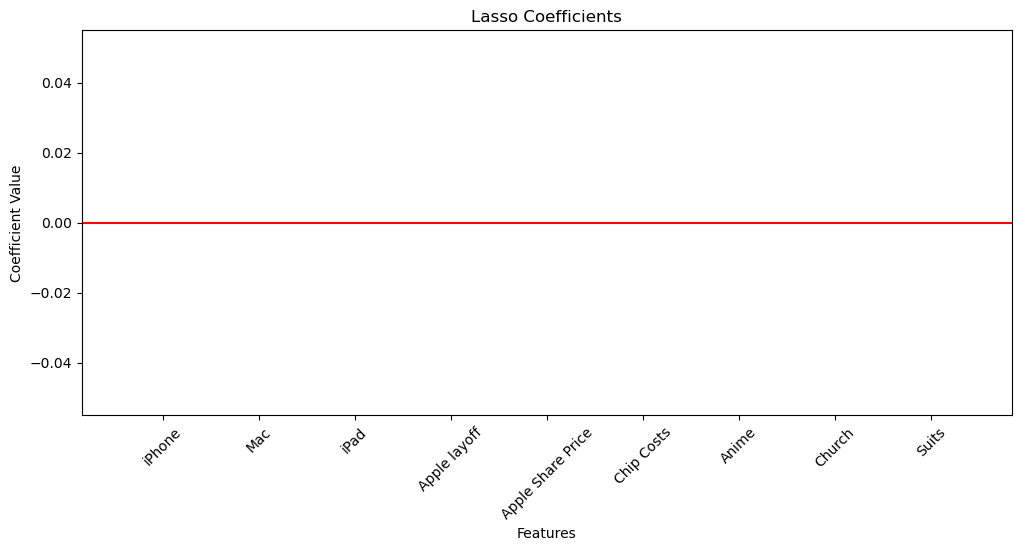

In [13]:
coefficients = lasso.coef_

plt.figure(figsize=(12, 5))
plt.bar(X.columns, coefficients)
plt.axhline(0, color="red")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.xticks(rotation=45)
plt.show()

# 5.) Do these coefficient magnitudes make sense?

### These coefficient magnitudes does not make sense because we pick a lambda that is too large. I will try and find the best lambda and run the fit model again. 

In [14]:
# Find the best lambda and fit the model again
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000, random_state=42)

y_train = y_train.values.ravel()

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"The best alpha (lambda) value is: {best_alpha}")

The best alpha (lambda) value is: 0.006977523236640827


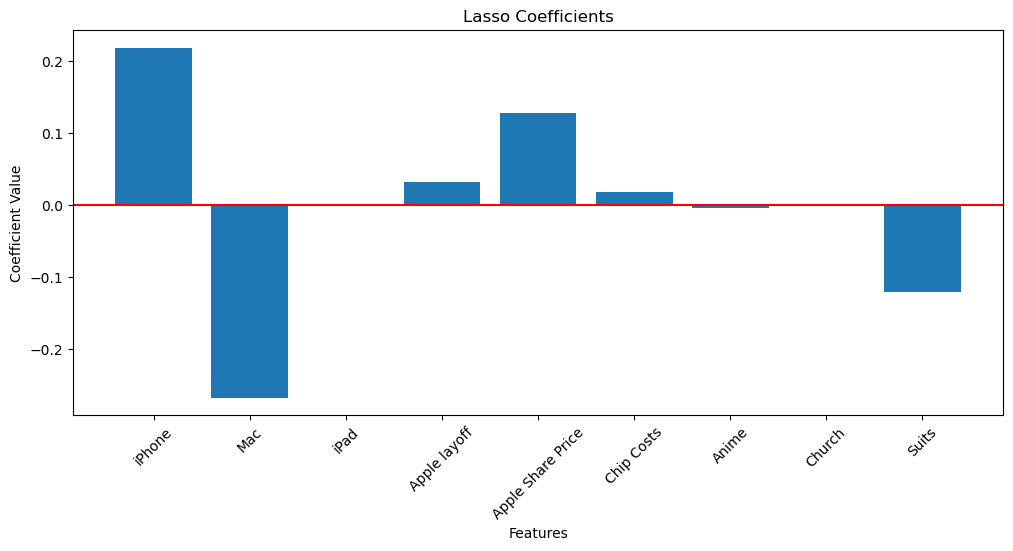

In [15]:
# Plot the graph
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)
coefficients2 = lasso_best.coef_

plt.figure(figsize=(12, 5))
plt.bar(X.columns, coefficients2)
plt.axhline(0, color="red")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.xticks(rotation=45)
plt.show()

### This result looks more interpretable. The trend of most Apple-related keywords positively correlates with the EPS, while the irrelevant keywords do not. However, the "Mac" keyword shows a robust negative correlation with the EPS, which might be worth investigating. 